In [16]:
from comet_ml import Experiment

In [5]:
import IPython.display as ipd

In [74]:
import os

In [6]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

/home/salah/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [37]:
import librosa.display

In [7]:
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


 let’s create a Comet experiment as a wrapper for all of our work. We’ll be able to capture any and all artifacts (audio files, visualizations, model, dataset, system information, training metrics, etc.) automatically

In [17]:
experiment = Experiment(api_key="ouyPwSDM4uKaOytZJ6oWP4MV8",project_name="urbansound8k")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shakkeelbhat/urbansound8k/18f5c6f0bffe47c5a498c58a34bb7026



In [18]:
df = pd.read_csv('/home/salah/Desktop/audio/UrbanSound8K.csv')

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.


In [21]:
labels = list(df['class'].unique())

In [30]:
files = dict() #one file from each class
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = '/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

In [31]:
files

{'dog_bark': '/home/salah/Desktop/audio/audio/fold5/100032-3-0-0.wav',
 'children_playing': '/home/salah/Desktop/audio/audio/fold5/100263-2-0-117.wav',
 'car_horn': '/home/salah/Desktop/audio/audio/fold10/100648-1-0-0.wav',
 'air_conditioner': '/home/salah/Desktop/audio/audio/fold5/100852-0-0-0.wav',
 'street_music': '/home/salah/Desktop/audio/audio/fold7/101848-9-0-0.wav',
 'gun_shot': '/home/salah/Desktop/audio/audio/fold1/102305-6-0-0.wav',
 'siren': '/home/salah/Desktop/audio/audio/fold7/102853-8-0-0.wav',
 'engine_idling': '/home/salah/Desktop/audio/audio/fold10/102857-5-0-0.wav',
 'jackhammer': '/home/salah/Desktop/audio/audio/fold1/103074-7-0-0.wav',
 'drilling': '/home/salah/Desktop/audio/audio/fold3/103199-4-0-0.wav'}

# visualize a single file

In [39]:
fig2 = plt.figure(figsize=(15,15))

<Figure size 1080x1080 with 0 Axes>

In [40]:
experiment.log_image('class_examples.png')

COMET ERROR: We failed to read file /home/salah/Desktop/audio/class_examples.png for uploading.
Please double-check the file path and permissions


In [42]:
fig2.subplots_adjust(hspace=0.4, wspace=0.4)

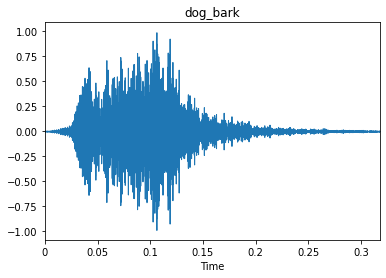

In [43]:

fn = files['dog_bark']
fig2.add_subplot(5, 2, 1)
plt.title('dog_bark')
data, sample_rate = librosa.load(fn)
librosa.display.waveplot(data, sr= sample_rate)

## continue with the process

COMET ERROR: We failed to read file /home/salah/Desktop/audio/class_examples.png for uploading.
Please double-check the file path and permissions


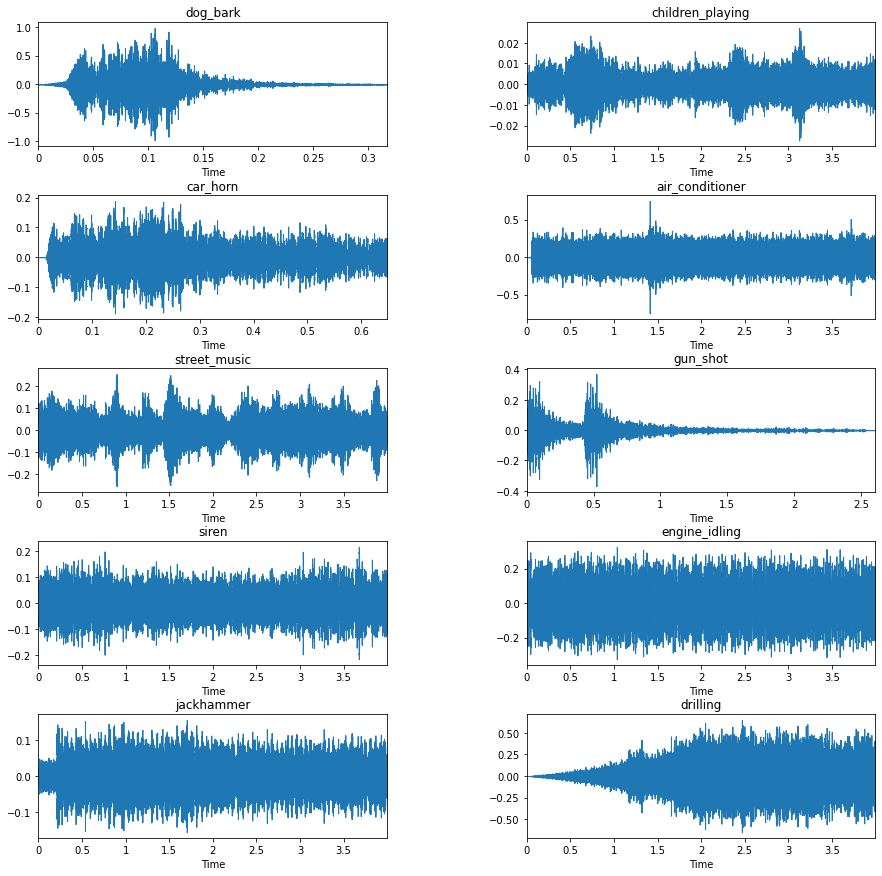

In [44]:
fig = plt.figure(figsize=(15,15))
experiment.log_image('class_examples.png')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')

# Log to comet

In [46]:
experiment.log_image('class_examples.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=44cd1b1d56ab49f291928214cfc8d536&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=44cd1b1d56ab49f291928214cfc8d536&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'imageId': '44cd1b1d56ab49f291928214cfc8d536'}

# For debugging, log audio files

In [47]:
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata = {'name': label})

# extract features now

# >librosa.load................vs................>wav.read

In [48]:
fn = '/audio/fold1/191431-9-0-66.wav'

In [49]:
librosa_audio, librosa_sample_rate = librosa.load(fn)

In [50]:
scipy_sample_rate, scipy_audio = wav.read(fn)

In [51]:
print("Original sample rate (using wav): {}".format(scipy_sample_rate))
print("Librosa sample rate (using librosa): {}".format(librosa_sample_rate))

Original sample rate (using wav): 48000
Librosa sample rate (using librosa): 22050


In [52]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))

Original audio file min~max range: -1869 to 1665


# normalize the bit depth

In [53]:
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Librosa audio file min~max range: -0.05 to -0.05


# audio signal to mono from stereo

### for the original audio

{'web': 'https://www.comet.ml/api/image/download?imageId=d3c46c6f305e43019fd29374b0d09138&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=d3c46c6f305e43019fd29374b0d09138&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'imageId': 'd3c46c6f305e43019fd29374b0d09138'}

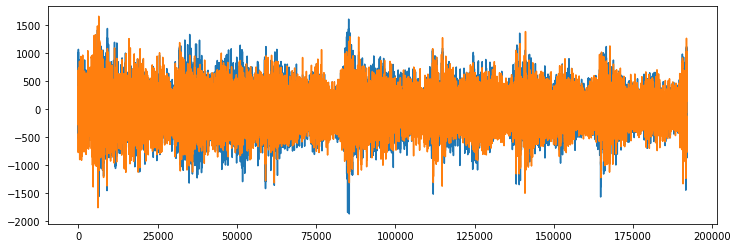

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')#two audio sources--stereo

# mono track using librosa

{'web': 'https://www.comet.ml/api/image/download?imageId=3f47374d1e264fcdbb3dc35be4f46ca1&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=3f47374d1e264fcdbb3dc35be4f46ca1&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'imageId': '3f47374d1e264fcdbb3dc35be4f46ca1'}

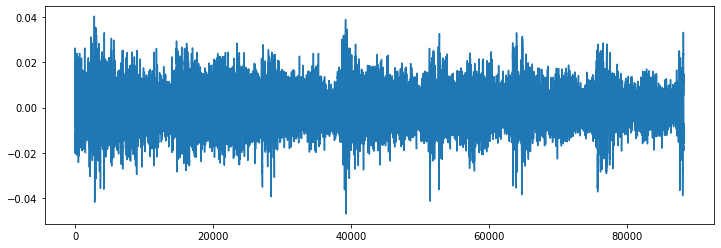

In [56]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

#  Feature extraction

## MFCCs using Librosa

In [58]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)

In [59]:
print(mfccs.shape)

(40, 173)


In [61]:
#mfccs

# 40 MFCCs over a 173 frame audio sample got calculated

{'web': 'https://www.comet.ml/api/image/download?imageId=f5ac0d9f57654285a153bd0571f41a23&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=f5ac0d9f57654285a153bd0571f41a23&experimentKey=18f5c6f0bffe47c5a498c58a34bb7026',
 'imageId': 'f5ac0d9f57654285a153bd0571f41a23'}

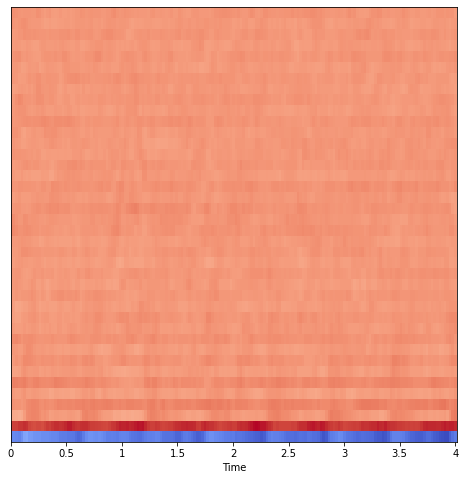

In [63]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

In [64]:
# function to extract MFCCs

In [65]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    return mfccs_processed

### resampy is for efficient time-series resampling. It is based on the band-limited sinc interpolation method for sampling rate conversion
res_type : str
        resample type (see note)

        note::
            By default, this uses `resampy`'s high-quality mode ('kaiser_best').

            To use a faster method, set `res_type='kaiser_fast'`.

            To use `scipy.signal.resample`, set `res_type='scip
            

## Steps for calculating MFCCs for a given audio sample:

    Slice the signal into short frames (of time)
    Compute the periodogram estimate of the power spectrum for each frame
    Apply the mel filterbank to the power spectra and sum the energy in each filter
    Take the discrete cosine transform (DCT) of the log filterbank energies

# MFCC ?
The main point to understand about speech is that the sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. This shape determines what sound comes out. If we can determine the shape accurately, this should give us an accurate representation of the phoneme being produced. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope. 

##### What is the Mel scale?

The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear.

The formula for converting from frequency to Mel scale is:
M(f) = 1125*ln(1 + f/700)

To go from Mels back to frequency:
M^-1(m) = 700*(exp(m/1125) -1)


In [79]:
features = []
for index, row in df.iterrows():
    file_name = os.path.join(os.path.abspath('audio'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])
# As a dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/home/salah/Desktop/audio/audio/fold5/100032-3-0-0.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-117.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-121.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-126.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-137.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-143.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-161.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-3.wav
/home/salah/Desktop/audio/audio/fold5/100263-2-0-36.wav
/home/salah/Desktop/audio/audio/fold10/100648-1-0-0.wav
/home/salah/Desktop/audio/audio/fold10/100648-1-1-0.wav
/home/salah/Desktop/audio/audio/fold10/100648-1-2-0.wav
/home/salah/Desktop/audio/audio/fold10/100648-1-3-0.wav
/home/salah/Desktop/audio/audio/fold10/100648-1-4-0.wav
/home/salah/Desktop/audio/audio/fold2/100652-3-0-0.wav
/home/salah/Desktop/audio/audio/fold2/100652-3-0-1.wav
/home/salah/Desktop/audio/audio/fold2/100652-3-0-2.wav
/home/salah/Desktop/audio/audio/fold2/100652-3-

/home/salah/Desktop/audio/audio/fold10/102857-5-0-5.wav
/home/salah/Desktop/audio/audio/fold10/102857-5-0-6.wav
/home/salah/Desktop/audio/audio/fold10/102857-5-0-7.wav
/home/salah/Desktop/audio/audio/fold10/102857-5-0-8.wav
/home/salah/Desktop/audio/audio/fold10/102857-5-0-9.wav
/home/salah/Desktop/audio/audio/fold2/102858-5-0-0.wav
/home/salah/Desktop/audio/audio/fold2/102858-5-0-1.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-0.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-1.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-10.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-11.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-12.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-13.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-14.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-15.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-2.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-3.wav
/home/salah/Desktop/audio/audio/fold2/102871-8-0-4.wav

/home/salah/Desktop/audio/audio/fold2/104817-4-0-0.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-1.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-10.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-11.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-2.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-3.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-4.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-5.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-6.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-7.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-8.wav
/home/salah/Desktop/audio/audio/fold2/104817-4-0-9.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-0-5.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-10-1.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-10-10.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-10-13.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-10-15.wav
/home/salah/Desktop/audio/audio/fold5/104998-7-10-8.wav


/home/salah/Desktop/audio/audio/fold1/105415-2-0-15.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-19.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-21.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-24.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-4.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-6.wav
/home/salah/Desktop/audio/audio/fold1/105415-2-0-8.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-1.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-10.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-12.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-13.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-14.wav
/home/salah/Desktop/audio/audio/fold5/105425-9-0-23.wav
/home/salah/Desktop/audio/audio/fold10/106014-5-0-0.wav
/home/salah/Desktop/audio/audio/fold10/106014-5-0-1.wav
/home/salah/Desktop/audio/audio/fold10/106014-5-0-2.wav
/home/salah/Desktop/audio/audio/fold10/106014-5-0-3.wav
/home/salah/Desktop/audio/audio/fold10/106014-5-0-4.

/home/salah/Desktop/audio/audio/fold2/109703-2-0-14.wav
/home/salah/Desktop/audio/audio/fold2/109703-2-0-153.wav
/home/salah/Desktop/audio/audio/fold2/109703-2-0-29.wav
/home/salah/Desktop/audio/audio/fold2/109703-2-0-32.wav
/home/salah/Desktop/audio/audio/fold2/109703-2-0-48.wav
/home/salah/Desktop/audio/audio/fold2/109703-2-0-50.wav
/home/salah/Desktop/audio/audio/fold4/109711-3-1-0.wav
/home/salah/Desktop/audio/audio/fold4/109711-3-2-4.wav
/home/salah/Desktop/audio/audio/fold4/109711-3-2-6.wav
/home/salah/Desktop/audio/audio/fold8/110134-3-0-0.wav
/home/salah/Desktop/audio/audio/fold5/110371-3-0-1.wav
/home/salah/Desktop/audio/audio/fold5/110371-3-1-0.wav
/home/salah/Desktop/audio/audio/fold5/110371-3-1-1.wav
/home/salah/Desktop/audio/audio/fold9/110389-3-0-0.wav
/home/salah/Desktop/audio/audio/fold4/110621-7-0-0.wav
/home/salah/Desktop/audio/audio/fold4/110621-7-0-1.wav
/home/salah/Desktop/audio/audio/fold4/110621-7-0-2.wav
/home/salah/Desktop/audio/audio/fold4/110621-7-0-3.wav
/ho

/home/salah/Desktop/audio/audio/fold1/113205-5-1-2.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-3.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-4.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-5.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-6.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-7.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-8.wav
/home/salah/Desktop/audio/audio/fold1/113205-5-1-9.wav
/home/salah/Desktop/audio/audio/fold8/113216-5-0-0.wav
/home/salah/Desktop/audio/audio/fold8/113216-5-0-1.wav
/home/salah/Desktop/audio/audio/fold8/113216-5-0-2.wav
/home/salah/Desktop/audio/audio/fold8/113216-5-0-3.wav
/home/salah/Desktop/audio/audio/fold8/113216-5-0-4.wav
/home/salah/Desktop/audio/audio/fold5/113601-9-0-22.wav
/home/salah/Desktop/audio/audio/fold5/113601-9-0-3.wav
/home/salah/Desktop/audio/audio/fold5/113601-9-0-33.wav
/home/salah/Desktop/audio/audio/fold5/113601-9-0-34.wav
/home/salah/Desktop/audio/audio/fold5/113601-9-0-35.wav
/home/

/home/salah/Desktop/audio/audio/fold10/118278-4-0-5.wav
/home/salah/Desktop/audio/audio/fold10/118278-4-0-6.wav
/home/salah/Desktop/audio/audio/fold10/118278-4-0-7.wav
/home/salah/Desktop/audio/audio/fold10/118278-4-0-8.wav
/home/salah/Desktop/audio/audio/fold10/118278-4-0-9.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-0.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-1.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-10.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-11.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-12.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-13.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-14.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-2.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-3.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-4.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-5.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-6.wav
/home/salah/Desktop/audio/audio/fold1/118279-8-0-7.wav


/home/salah/Desktop/audio/audio/fold2/123688-8-0-6.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-0-7.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-0-8.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-0-9.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-0.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-1.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-2.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-3.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-4.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-1-5.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-2-0.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-2-1.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-2-2.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-2-3.wav
/home/salah/Desktop/audio/audio/fold2/123688-8-2-4.wav
/home/salah/Desktop/audio/audio/fold6/124389-8-1-0.wav
/home/salah/Desktop/audio/audio/fold6/124389-8-1-1.wav
/home/salah/Desktop/audio/audio/fold6/124389-8-1-10.wav
/home/sal

/home/salah/Desktop/audio/audio/fold4/128160-5-0-13.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-14.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-15.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-2.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-3.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-4.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-5.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-6.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-7.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-8.wav
/home/salah/Desktop/audio/audio/fold4/128160-5-0-9.wav
/home/salah/Desktop/audio/audio/fold10/128240-3-0-1.wav
/home/salah/Desktop/audio/audio/fold10/128240-3-0-20.wav
/home/salah/Desktop/audio/audio/fold10/128240-3-0-39.wav
/home/salah/Desktop/audio/audio/fold10/128240-3-0-42.wav
/home/salah/Desktop/audio/audio/fold6/128465-1-0-0.wav
/home/salah/Desktop/audio/audio/fold6/128465-1-0-1.wav
/home/salah/Desktop/audio/audio/fold6/128465-1-0-2.wav


/home/salah/Desktop/audio/audio/fold3/13230-0-0-22.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-23.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-24.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-25.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-26.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-27.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-28.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-3.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-5.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-6.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-7.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-8.wav
/home/salah/Desktop/audio/audio/fold3/13230-0-0-9.wav
/home/salah/Desktop/audio/audio/fold3/132855-2-0-113.wav
/home/salah/Desktop/audio/audio/fold3/132855-2-0-41.wav
/home/salah/Desktop/audio/audio/fold3/132855-2-0-58.wav
/home/salah/Desktop/audio/audio/fold3/132855-2-0-70.wav
/home/salah/Desktop/audio/audio/fold3/132855-2-0-77.wav
/home/sala

/home/salah/Desktop/audio/audio/fold6/135544-6-3-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-4-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-5-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-6-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-7-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-8-0.wav
/home/salah/Desktop/audio/audio/fold6/135544-6-9-0.wav
/home/salah/Desktop/audio/audio/fold5/13577-3-0-0.wav
/home/salah/Desktop/audio/audio/fold5/13577-3-0-2.wav
/home/salah/Desktop/audio/audio/fold5/13577-3-5-0.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-32.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-37.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-40.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-49.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-50.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-65.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-85.wav
/home/salah/Desktop/audio/audio/fold1/135776-2-0-90.wav
/home

/home/salah/Desktop/audio/audio/fold10/142641-3-0-0.wav
/home/salah/Desktop/audio/audio/fold6/143115-1-0-0.wav
/home/salah/Desktop/audio/audio/fold6/143115-1-1-0.wav
/home/salah/Desktop/audio/audio/fold6/143115-1-2-0.wav
/home/salah/Desktop/audio/audio/fold6/143115-1-3-0.wav
/home/salah/Desktop/audio/audio/fold6/143115-1-4-0.wav
/home/salah/Desktop/audio/audio/fold6/14358-3-0-26.wav
/home/salah/Desktop/audio/audio/fold6/14358-3-0-7.wav
/home/salah/Desktop/audio/audio/fold6/14358-3-0-85.wav
/home/salah/Desktop/audio/audio/fold6/14358-3-0-90.wav
/home/salah/Desktop/audio/audio/fold1/143604-5-0-0.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-0.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-16.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-20.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-22.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-39.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-55.wav
/home/salah/Desktop/audio/audio/fold1/143651-2-0-59.wav
/hom

/home/salah/Desktop/audio/audio/fold8/145206-6-5-0.wav
/home/salah/Desktop/audio/audio/fold7/14524-1-0-0.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-0.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-2.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-3.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-4.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-5.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-6.wav
/home/salah/Desktop/audio/audio/fold9/14527-9-0-7.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-13.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-15.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-22.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-26.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-3.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-34.wav
/home/salah/Desktop/audio/audio/fold9/145390-9-0-7.wav
/home/salah/Desktop/audio/audio/fold2/145577-1-0-0.wav
/home/salah/Desktop/audio/audio/fold2/145608-6-0-0.wav
/home/salah/D

/home/salah/Desktop/audio/audio/fold7/146845-0-0-3.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-30.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-31.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-32.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-33.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-35.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-36.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-5.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-6.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-7.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-8.wav
/home/salah/Desktop/audio/audio/fold7/146845-0-0-9.wav
/home/salah/Desktop/audio/audio/fold8/147019-4-0-0.wav
/home/salah/Desktop/audio/audio/fold7/147317-6-0-0.wav
/home/salah/Desktop/audio/audio/fold10/147491-9-0-0.wav
/home/salah/Desktop/audio/audio/fold10/147491-9-0-5.wav
/home/salah/Desktop/audio/audio/fold10/147491-9-2-10.wav
/home/salah/Desktop/audio/audio/fold10/147491-9-2-25.wa

/home/salah/Desktop/audio/audio/fold2/149370-9-0-21.wav
/home/salah/Desktop/audio/audio/fold2/149370-9-0-22.wav
/home/salah/Desktop/audio/audio/fold2/149370-9-0-32.wav
/home/salah/Desktop/audio/audio/fold2/149370-9-0-37.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-0-0.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-0-2.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-0-5.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-1-0.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-1-1.wav
/home/salah/Desktop/audio/audio/fold9/149929-9-1-4.wav
/home/salah/Desktop/audio/audio/fold1/150341-3-0-0.wav
/home/salah/Desktop/audio/audio/fold1/150341-3-1-0.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-0-0.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-0-1.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-0-2.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-0-3.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-1-0.wav
/home/salah/Desktop/audio/audio/fold4/151005-4-1-1.wav
/home/

/home/salah/Desktop/audio/audio/fold2/155219-2-0-24.wav
/home/salah/Desktop/audio/audio/fold2/155219-2-0-25.wav
/home/salah/Desktop/audio/audio/fold2/155219-2-0-26.wav
/home/salah/Desktop/audio/audio/fold2/155219-2-0-51.wav
/home/salah/Desktop/audio/audio/fold2/155219-2-0-57.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-2.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-20.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-23.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-24.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-27.wav
/home/salah/Desktop/audio/audio/fold3/155227-9-0-3.wav
/home/salah/Desktop/audio/audio/fold2/155234-1-0-0.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-17.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-3.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-31.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-36.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-47.wav
/home/salah/Desktop/audio/audio/fold7/155238-2-0-67.

/home/salah/Desktop/audio/audio/fold5/156634-5-0-8.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-0-9.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-1-0.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-0.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-1.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-2.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-3.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-4.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-5.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-6.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-7.wav
/home/salah/Desktop/audio/audio/fold5/156634-5-2-8.wav
/home/salah/Desktop/audio/audio/fold4/156868-8-0-0.wav
/home/salah/Desktop/audio/audio/fold4/156868-8-1-0.wav
/home/salah/Desktop/audio/audio/fold4/156868-8-2-0.wav
/home/salah/Desktop/audio/audio/fold4/156868-8-3-0.wav
/home/salah/Desktop/audio/audio/fold4/156868-8-4-0.wav
/home/salah/Desktop/audio/audio/fold5/156869-8-0-0.wav
/home/sala

/home/salah/Desktop/audio/audio/fold8/157868-8-0-5.wav
/home/salah/Desktop/audio/audio/fold8/157868-8-0-6.wav
/home/salah/Desktop/audio/audio/fold8/157868-8-0-7.wav
/home/salah/Desktop/audio/audio/fold8/157868-8-0-8.wav
/home/salah/Desktop/audio/audio/fold8/157868-8-0-9.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-0.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-2.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-3.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-4.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-5.wav
/home/salah/Desktop/audio/audio/fold7/157940-9-0-6.wav
/home/salah/Desktop/audio/audio/fold7/157950-3-0-0.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-0.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-31.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-43.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-47.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-52.wav
/home/salah/Desktop/audio/audio/fold7/158593-2-0-54.wav
/home

/home/salah/Desktop/audio/audio/fold2/159747-8-0-0.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-1.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-10.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-11.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-12.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-13.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-14.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-15.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-16.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-17.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-18.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-19.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-2.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-20.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-21.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-3.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-4.wav
/home/salah/Desktop/audio/audio/fold2/159747-8-0-5.wa

/home/salah/Desktop/audio/audio/fold2/160366-3-0-4.wav
/home/salah/Desktop/audio/audio/fold2/160366-3-0-7.wav
/home/salah/Desktop/audio/audio/fold2/160366-3-0-8.wav
/home/salah/Desktop/audio/audio/fold6/160575-3-0-0.wav
/home/salah/Desktop/audio/audio/fold6/160575-3-1-0.wav
/home/salah/Desktop/audio/audio/fold6/160575-3-4-0.wav
/home/salah/Desktop/audio/audio/fold6/160575-3-7-0.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-0.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-12.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-14.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-19.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-27.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-28.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-4.wav
/home/salah/Desktop/audio/audio/fold9/161005-2-0-6.wav
/home/salah/Desktop/audio/audio/fold4/161010-1-0-0.wav
/home/salah/Desktop/audio/audio/fold4/161010-1-1-0.wav
/home/salah/Desktop/audio/audio/fold4/161010-1-2-0.wav
/home

/home/salah/Desktop/audio/audio/fold5/162432-6-13-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-14-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-2-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-3-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-4-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-5-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-6-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-7-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-8-0.wav
/home/salah/Desktop/audio/audio/fold5/162432-6-9-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-0-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-1-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-2-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-3-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-4-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-5-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-6-0.wav
/home/salah/Desktop/audio/audio/fold8/162433-6-7-0.wav
/home/sa

/home/salah/Desktop/audio/audio/fold9/165454-0-0-2.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-3.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-4.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-5.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-6.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-7.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-8.wav
/home/salah/Desktop/audio/audio/fold9/165454-0-0-9.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-18.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-3.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-6.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-70.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-73.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-8.wav
/home/salah/Desktop/audio/audio/fold7/165529-2-0-90.wav
/home/salah/Desktop/audio/audio/fold9/165567-3-0-0.wav
/home/salah/Desktop/audio/audio/fold9/165567-3-2-0.wav
/home/salah/Desktop/audio/audio/fold9/165567-3-3-0.wav
/home/

/home/salah/Desktop/audio/audio/fold6/167701-4-6-1.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-6-2.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-6-3.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-6-4.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-7-0.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-9-0.wav
/home/salah/Desktop/audio/audio/fold6/167701-4-9-1.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-0-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-1-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-2-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-3-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-4-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-5-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-6-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-7-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-7-1.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-8-0.wav
/home/salah/Desktop/audio/audio/fold8/167702-4-9-0.wav
/home/sala

/home/salah/Desktop/audio/audio/fold8/17009-2-0-6.wav
/home/salah/Desktop/audio/audio/fold8/17009-2-0-9.wav
/home/salah/Desktop/audio/audio/fold7/170243-1-0-0.wav
/home/salah/Desktop/audio/audio/fold5/170245-0-0-0.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-0-0.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-0-3.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-22.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-27.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-31.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-32.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-34.wav
/home/salah/Desktop/audio/audio/fold4/170564-2-1-9.wav
/home/salah/Desktop/audio/audio/fold10/17074-1-0-0.wav
/home/salah/Desktop/audio/audio/fold7/171165-9-0-103.wav
/home/salah/Desktop/audio/audio/fold7/171165-9-0-15.wav
/home/salah/Desktop/audio/audio/fold7/171165-9-0-19.wav
/home/salah/Desktop/audio/audio/fold7/171165-9-0-54.wav
/home/salah/Desktop/audio/audio/fold7/171165-9-0-70.wav
/

/home/salah/Desktop/audio/audio/fold4/174026-3-1-5.wav
/home/salah/Desktop/audio/audio/fold4/174026-3-2-2.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-1.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-11.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-17.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-18.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-22.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-26.wav
/home/salah/Desktop/audio/audio/fold4/174032-2-0-4.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-0-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-1-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-2-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-3-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-4-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-5-0.wav
/home/salah/Desktop/audio/audio/fold1/174276-7-6-0.wav
/home/salah/Desktop/audio/audio/fold9/174282-6-0-0.wav
/home/salah/Desktop/audio/audio/fold9/174282-6-1-0.wav
/home

/home/salah/Desktop/audio/audio/fold9/175915-3-0-1.wav
/home/salah/Desktop/audio/audio/fold9/175915-3-0-3.wav
/home/salah/Desktop/audio/audio/fold9/175915-3-1-8.wav
/home/salah/Desktop/audio/audio/fold6/175917-3-0-3.wav
/home/salah/Desktop/audio/audio/fold6/175917-3-1-1.wav
/home/salah/Desktop/audio/audio/fold6/175917-3-2-2.wav
/home/salah/Desktop/audio/audio/fold6/175917-3-4-1.wav
/home/salah/Desktop/audio/audio/fold1/17592-5-0-0.wav
/home/salah/Desktop/audio/audio/fold1/17592-5-1-0.wav
/home/salah/Desktop/audio/audio/fold1/17592-5-1-1.wav
/home/salah/Desktop/audio/audio/fold1/17592-5-1-2.wav
/home/salah/Desktop/audio/audio/fold1/17592-5-1-3.wav
/home/salah/Desktop/audio/audio/fold4/176003-1-0-0.wav
/home/salah/Desktop/audio/audio/fold3/17615-3-0-0.wav
/home/salah/Desktop/audio/audio/fold3/17615-3-0-3.wav
/home/salah/Desktop/audio/audio/fold3/17615-3-0-4.wav
/home/salah/Desktop/audio/audio/fold3/17615-3-0-6.wav
/home/salah/Desktop/audio/audio/fold1/176257-3-0-0.wav
/home/salah/Desktop

/home/salah/Desktop/audio/audio/fold1/177621-0-0-46.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-47.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-48.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-54.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-57.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-80.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-88.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-91.wav
/home/salah/Desktop/audio/audio/fold1/177621-0-0-93.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-1.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-10.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-11.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-12.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-13.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-14.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-15.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-17.wav
/home/salah/Desktop/audio/audio/fold8/177726-0-0-

/home/salah/Desktop/audio/audio/fold5/178260-7-6-0.wav
/home/salah/Desktop/audio/audio/fold5/178260-7-7-0.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-0-0.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-1-0.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-2-0.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-0.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-1.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-2.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-3.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-4.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-5.wav
/home/salah/Desktop/audio/audio/fold10/178261-7-3-6.wav
/home/salah/Desktop/audio/audio/fold10/178402-1-0-0.wav
/home/salah/Desktop/audio/audio/fold5/178497-3-0-1.wav
/home/salah/Desktop/audio/audio/fold5/178497-3-0-3.wav
/home/salah/Desktop/audio/audio/fold5/178497-3-0-4.wav
/home/salah/Desktop/audio/audio/fold5/178497-3-0-6.wav
/home/salah/Desktop/audio/audio/fold2/178520-2-0-11.wa

/home/salah/Desktop/audio/audio/fold9/180029-4-19-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-2-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-20-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-4-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-5-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-6-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-7-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-8-0.wav
/home/salah/Desktop/audio/audio/fold9/180029-4-9-0.wav
/home/salah/Desktop/audio/audio/fold5/180052-3-0-0.wav
/home/salah/Desktop/audio/audio/fold5/180052-3-0-1.wav
/home/salah/Desktop/audio/audio/fold5/180052-3-0-3.wav
/home/salah/Desktop/audio/audio/fold5/180052-3-0-4.wav
/home/salah/Desktop/audio/audio/fold3/180057-9-0-11.wav
/home/salah/Desktop/audio/audio/fold3/180057-9-0-20.wav
/home/salah/Desktop/audio/audio/fold3/180057-9-0-34.wav
/home/salah/Desktop/audio/audio/fold3/180057-9-0-36.wav
/home/salah/Desktop/audio/audio/fold3/180057-9-0-5.wav
/hom

/home/salah/Desktop/audio/audio/fold1/180937-7-0-4.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-0-5.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-0-6.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-0.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-1.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-10.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-11.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-12.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-13.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-14.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-15.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-2.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-3.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-4.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-5.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-6.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-7.wav
/home/salah/Desktop/audio/audio/fold1/180937-7-1-8.wav
/hom

/home/salah/Desktop/audio/audio/fold9/184575-3-0-2.wav
/home/salah/Desktop/audio/audio/fold9/184575-3-0-3.wav
/home/salah/Desktop/audio/audio/fold3/184623-8-0-0.wav
/home/salah/Desktop/audio/audio/fold3/184623-8-0-1.wav
/home/salah/Desktop/audio/audio/fold3/184623-8-0-2.wav
/home/salah/Desktop/audio/audio/fold3/184623-8-0-3.wav
/home/salah/Desktop/audio/audio/fold3/184623-8-1-0.wav
/home/salah/Desktop/audio/audio/fold3/184725-3-0-1.wav
/home/salah/Desktop/audio/audio/fold3/184725-3-0-2.wav
/home/salah/Desktop/audio/audio/fold3/184725-3-0-4.wav
/home/salah/Desktop/audio/audio/fold3/184725-3-0-5.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-101.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-103.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-104.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-112.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-121.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-13.wav
/home/salah/Desktop/audio/audio/fold6/184805-0-0-16.wa

/home/salah/Desktop/audio/audio/fold10/187110-2-0-10.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-12.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-27.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-30.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-34.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-6.wav
/home/salah/Desktop/audio/audio/fold10/187110-2-0-8.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-0-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-1-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-2-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-3-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-4-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-5-0.wav
/home/salah/Desktop/audio/audio/fold4/187356-1-6-0.wav
/home/salah/Desktop/audio/audio/fold4/187377-4-0-0.wav
/home/salah/Desktop/audio/audio/fold4/187377-4-0-1.wav
/home/salah/Desktop/audio/audio/fold9/187378-3-0-12.wav
/home/salah/Desktop/audio/audio/fold9/187378-3-0-19.

/home/salah/Desktop/audio/audio/fold10/189982-0-0-35.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-36.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-38.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-39.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-4.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-42.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-43.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-44.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-45.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-6.wav
/home/salah/Desktop/audio/audio/fold10/189982-0-0-7.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-0.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-1.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-2.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-3.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-4.wav
/home/salah/Desktop/audio/audio/fold10/189985-0-0-5.wav
/home/salah/Desktop/audio/audio/fold10/1

/home/salah/Desktop/audio/audio/fold9/194310-9-0-3.wav
/home/salah/Desktop/audio/audio/fold9/194310-9-0-35.wav
/home/salah/Desktop/audio/audio/fold9/194310-9-0-7.wav
/home/salah/Desktop/audio/audio/fold9/194310-9-0-73.wav
/home/salah/Desktop/audio/audio/fold9/194310-9-0-8.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-100.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-126.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-150.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-241.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-6.wav
/home/salah/Desktop/audio/audio/fold6/194321-9-0-61.wav
/home/salah/Desktop/audio/audio/fold4/194458-9-0-2.wav
/home/salah/Desktop/audio/audio/fold4/194458-9-0-34.wav
/home/salah/Desktop/audio/audio/fold4/194458-9-1-122.wav
/home/salah/Desktop/audio/audio/fold4/194458-9-1-75.wav
/home/salah/Desktop/audio/audio/fold4/194458-9-1-91.wav
/home/salah/Desktop/audio/audio/fold1/194732-9-0-126.wav
/home/salah/Desktop/audio/audio/fold1/194732-9-

/home/salah/Desktop/audio/audio/fold5/196085-2-0-3.wav
/home/salah/Desktop/audio/audio/fold5/196085-2-0-4.wav
/home/salah/Desktop/audio/audio/fold10/196086-2-0-0.wav
/home/salah/Desktop/audio/audio/fold1/196087-2-0-0.wav
/home/salah/Desktop/audio/audio/fold6/196088-2-0-0.wav
/home/salah/Desktop/audio/audio/fold10/196127-3-0-0.wav
/home/salah/Desktop/audio/audio/fold10/196127-3-0-1.wav
/home/salah/Desktop/audio/audio/fold10/196127-3-0-3.wav
/home/salah/Desktop/audio/audio/fold10/196127-3-0-4.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-11.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-15.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-16.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-18.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-2.wav
/home/salah/Desktop/audio/audio/fold2/196384-9-0-27.wav
/home/salah/Desktop/audio/audio/fold1/196400-6-0-0.wav
/home/salah/Desktop/audio/audio/fold8/196561-3-0-16.wav
/home/salah/Desktop/audio/audio/fold8/196561-3-0-29.wa

/home/salah/Desktop/audio/audio/fold2/201652-5-5-0.wav
/home/salah/Desktop/audio/audio/fold2/201652-5-5-1.wav
/home/salah/Desktop/audio/audio/fold2/201652-5-5-2.wav
/home/salah/Desktop/audio/audio/fold2/201652-5-5-3.wav
/home/salah/Desktop/audio/audio/fold2/201652-5-5-4.wav
/home/salah/Desktop/audio/audio/fold2/201652-5-5-5.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-0.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-1.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-10.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-11.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-12.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-13.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-14.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-15.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-16.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-17.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-18.wav
/home/salah/Desktop/audio/audio/fold7/201988-5-0-19.wav


/home/salah/Desktop/audio/audio/fold2/203929-7-7-13.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-14.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-15.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-16.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-2.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-3.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-4.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-7-9.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-8-0.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-0.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-11.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-12.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-15.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-17.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-18.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-19.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-20.wav
/home/salah/Desktop/audio/audio/fold2/203929-7-9-24.wa

/home/salah/Desktop/audio/audio/fold8/207214-2-0-31.wav
/home/salah/Desktop/audio/audio/fold8/207214-2-0-54.wav
/home/salah/Desktop/audio/audio/fold8/207214-2-0-62.wav
/home/salah/Desktop/audio/audio/fold8/207214-2-0-63.wav
/home/salah/Desktop/audio/audio/fold8/207214-2-0-68.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-112.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-119.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-128.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-130.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-137.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-22.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-43.wav
/home/salah/Desktop/audio/audio/fold7/207216-2-0-66.wav
/home/salah/Desktop/audio/audio/fold8/207369-3-0-0.wav
/home/salah/Desktop/audio/audio/fold7/207962-3-0-0.wav
/home/salah/Desktop/audio/audio/fold7/207962-3-1-0.wav
/home/salah/Desktop/audio/audio/fold7/207962-3-2-0.wav
/home/salah/Desktop/audio/audio/fold6/208030-3-

/home/salah/Desktop/audio/audio/fold4/22883-7-21-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-23-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-24-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-27-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-28-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-29-2.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-3-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-33-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-34-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-35-2.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-35-3.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-36-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-36-1.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-36-2.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-37-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-39-0.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-39-1.wav
/home/salah/Desktop/audio/audio/fold4/22883-7-40-0.wav
/home/salah

/home/salah/Desktop/audio/audio/fold4/24347-8-0-56.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-57.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-58.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-59.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-6.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-60.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-61.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-62.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-63.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-64.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-65.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-66.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-67.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-68.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-69.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-7.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-70.wav
/home/salah/Desktop/audio/audio/fold4/24347-8-0-71.wav
/home/salah/

/home/salah/Desktop/audio/audio/fold10/28808-1-0-4.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-0-5.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-0-6.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-0-7.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-0-8.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-0-9.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-1-0.wav
/home/salah/Desktop/audio/audio/fold10/28808-1-1-1.wav
/home/salah/Desktop/audio/audio/fold10/2937-1-0-0.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-0.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-1.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-10.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-11.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-12.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-13.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-14.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-2.wav
/home/salah/Desktop/audio/audio/fold3/29721-4-0-3.wav
/home/salah/Des

/home/salah/Desktop/audio/audio/fold8/33340-7-16-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-2-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-3-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-4-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-5-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-6-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-7-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-8-0.wav
/home/salah/Desktop/audio/audio/fold8/33340-7-9-0.wav
/home/salah/Desktop/audio/audio/fold9/33641-3-1-0.wav
/home/salah/Desktop/audio/audio/fold9/33641-3-7-0.wav
/home/salah/Desktop/audio/audio/fold9/33641-3-8-0.wav
/home/salah/Desktop/audio/audio/fold9/33641-3-9-0.wav
/home/salah/Desktop/audio/audio/fold3/33696-3-0-0.wav
/home/salah/Desktop/audio/audio/fold3/33696-3-4-0.wav
/home/salah/Desktop/audio/audio/fold3/33696-3-4-1.wav
/home/salah/Desktop/audio/audio/fold3/33696-3-6-1.wav
/home/salah/Desktop/audio/audio/fold2/33849-3-0-0.wav
/home/salah/Desktop/audio/a

/home/salah/Desktop/audio/audio/fold3/37560-4-0-1.wav
/home/salah/Desktop/audio/audio/fold3/37560-4-0-2.wav
/home/salah/Desktop/audio/audio/fold3/37560-4-0-3.wav
/home/salah/Desktop/audio/audio/fold3/37560-4-0-4.wav
/home/salah/Desktop/audio/audio/fold3/37560-4-0-5.wav
/home/salah/Desktop/audio/audio/fold5/37869-3-0-0.wav
/home/salah/Desktop/audio/audio/fold5/37869-3-1-0.wav
/home/salah/Desktop/audio/audio/fold5/37869-3-3-0.wav
/home/salah/Desktop/audio/audio/fold5/37869-3-5-0.wav
/home/salah/Desktop/audio/audio/fold6/38121-3-0-0.wav
/home/salah/Desktop/audio/audio/fold4/38231-3-0-0.wav
/home/salah/Desktop/audio/audio/fold4/38231-3-2-0.wav
/home/salah/Desktop/audio/audio/fold4/38231-3-3-0.wav
/home/salah/Desktop/audio/audio/fold4/38231-3-4-0.wav
/home/salah/Desktop/audio/audio/fold7/38236-3-2-2.wav
/home/salah/Desktop/audio/audio/fold7/38236-3-2-3.wav
/home/salah/Desktop/audio/audio/fold7/38236-3-3-0.wav
/home/salah/Desktop/audio/audio/fold9/39532-4-0-0.wav
/home/salah/Desktop/audio/au

/home/salah/Desktop/audio/audio/fold3/42117-8-0-1.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-10.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-11.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-12.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-13.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-14.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-2.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-3.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-4.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-5.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-6.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-7.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-8.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-0-9.wav
/home/salah/Desktop/audio/audio/fold3/42117-8-1-0.wav
/home/salah/Desktop/audio/audio/fold8/42324-4-0-0.wav
/home/salah/Desktop/audio/audio/fold8/42324-4-1-0.wav
/home/salah/Desktop/audio/audio/fold8/42324-4-2-0.wav
/home/salah/Desktop/aud

/home/salah/Desktop/audio/audio/fold8/4918-3-1-0.wav
/home/salah/Desktop/audio/audio/fold8/4918-3-3-0.wav
/home/salah/Desktop/audio/audio/fold8/4918-3-4-0.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-1.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-10.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-16.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-17.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-2.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-5.wav
/home/salah/Desktop/audio/audio/fold5/49312-2-0-7.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-1.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-10.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-13.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-20.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-30.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-4.wav
/home/salah/Desktop/audio/audio/fold7/49313-2-0-9.wav
/home/salah/Desktop/audio/audio/fold3/49485-9-0-138.wav
/home/salah/Desktop/au

/home/salah/Desktop/audio/audio/fold3/54067-2-0-70.wav
/home/salah/Desktop/audio/audio/fold3/54067-2-0-71.wav
/home/salah/Desktop/audio/audio/fold3/54067-2-0-80.wav
/home/salah/Desktop/audio/audio/fold4/54081-9-0-24.wav
/home/salah/Desktop/audio/audio/fold4/54081-9-0-47.wav
/home/salah/Desktop/audio/audio/fold4/54081-9-0-56.wav
/home/salah/Desktop/audio/audio/fold4/54081-9-0-87.wav
/home/salah/Desktop/audio/audio/fold4/54081-9-0-93.wav
/home/salah/Desktop/audio/audio/fold10/54086-1-0-0.wav
/home/salah/Desktop/audio/audio/fold10/54086-1-1-0.wav
/home/salah/Desktop/audio/audio/fold10/54086-1-2-0.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-18.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-2.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-21.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-26.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-28.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-4.wav
/home/salah/Desktop/audio/audio/fold4/54173-2-0-5.wav
/home/salah/D

/home/salah/Desktop/audio/audio/fold1/57320-0-0-37.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-38.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-39.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-4.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-42.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-45.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-5.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-6.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-7.wav
/home/salah/Desktop/audio/audio/fold1/57320-0-0-9.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-0.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-1.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-10.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-11.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-2.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-3.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-4.wav
/home/salah/Desktop/audio/audio/fold7/57323-8-0-5.wav
/home/salah/Desktop/a

/home/salah/Desktop/audio/audio/fold8/61077-3-0-0.wav
/home/salah/Desktop/audio/audio/fold8/61077-3-1-0.wav
/home/salah/Desktop/audio/audio/fold8/61077-3-2-0.wav
/home/salah/Desktop/audio/audio/fold8/61077-3-3-0.wav
/home/salah/Desktop/audio/audio/fold9/61250-3-0-31.wav
/home/salah/Desktop/audio/audio/fold9/61250-3-0-36.wav
/home/salah/Desktop/audio/audio/fold9/61250-3-0-47.wav
/home/salah/Desktop/audio/audio/fold9/61250-3-0-62.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-0.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-2.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-3.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-5.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-6.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-7.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-8.wav
/home/salah/Desktop/audio/audio/fold7/61503-2-0-9.wav
/home/salah/Desktop/audio/audio/fold4/61626-9-0-10.wav
/home/salah/Desktop/audio/audio/fold4/61626-9-0-12.wav
/home/salah/Desktop/au

/home/salah/Desktop/audio/audio/fold7/62878-8-0-1.wav
/home/salah/Desktop/audio/audio/fold7/62878-8-0-2.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-1.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-10.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-14.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-16.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-20.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-21.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-26.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-28.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-29.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-4.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-6.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-0-8.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-1-10.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-1-18.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-1-19.wav
/home/salah/Desktop/audio/audio/fold3/63095-4-1-20.wav
/home/salah/Desk

/home/salah/Desktop/audio/audio/fold1/69304-9-0-12.wav
/home/salah/Desktop/audio/audio/fold1/69304-9-0-14.wav
/home/salah/Desktop/audio/audio/fold1/69304-9-0-15.wav
/home/salah/Desktop/audio/audio/fold1/69304-9-0-6.wav
/home/salah/Desktop/audio/audio/fold1/69304-9-0-7.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-0-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-1-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-2-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-2-1.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-3-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-4-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-5-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-6-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-6-1.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-7-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-8-0.wav
/home/salah/Desktop/audio/audio/fold3/69598-4-9-0.wav
/home/salah/Desktop/audio/audio/fold10/69661-3-0-14.wav
/home/salah/Desktop/aud

/home/salah/Desktop/audio/audio/fold7/71866-9-0-3.wav
/home/salah/Desktop/audio/audio/fold7/71866-9-0-31.wav
/home/salah/Desktop/audio/audio/fold7/71866-9-0-32.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-0.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-1.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-2.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-3.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-4.wav
/home/salah/Desktop/audio/audio/fold8/72015-2-0-5.wav
/home/salah/Desktop/audio/audio/fold10/72220-3-0-0.wav
/home/salah/Desktop/audio/audio/fold10/72220-3-2-2.wav
/home/salah/Desktop/audio/audio/fold10/72220-3-2-3.wav
/home/salah/Desktop/audio/audio/fold10/72220-3-2-4.wav
/home/salah/Desktop/audio/audio/fold8/72221-3-1-0.wav
/home/salah/Desktop/audio/audio/fold8/72221-3-4-1.wav
/home/salah/Desktop/audio/audio/fold8/72221-3-4-5.wav
/home/salah/Desktop/audio/audio/fold8/72221-3-4-7.wav
/home/salah/Desktop/audio/audio/fold5/72259-1-0-0.wav
/home/salah/Desktop/au

/home/salah/Desktop/audio/audio/fold10/73524-0-0-105.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-113.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-114.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-126.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-127.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-128.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-133.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-137.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-2.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-23.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-30.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-31.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-32.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-5.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-52.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-54.wav
/home/salah/Desktop/audio/audio/fold10/73524-0-0-6.wav
/home/salah/Desktop/audio/audio/fold10/7352

/home/salah/Desktop/audio/audio/fold8/74677-0-0-116.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-13.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-130.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-134.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-135.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-14.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-19.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-2.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-21.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-28.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-3.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-35.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-36.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-38.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-47.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-56.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-57.wav
/home/salah/Desktop/audio/audio/fold8/74677-0-0-58.wav
/home/sa

/home/salah/Desktop/audio/audio/fold2/76086-4-0-53.wav
/home/salah/Desktop/audio/audio/fold2/76086-4-0-55.wav
/home/salah/Desktop/audio/audio/fold2/76086-4-0-56.wav
/home/salah/Desktop/audio/audio/fold2/76086-4-0-58.wav
/home/salah/Desktop/audio/audio/fold2/76089-6-0-0.wav
/home/salah/Desktop/audio/audio/fold2/76090-6-0-0.wav
/home/salah/Desktop/audio/audio/fold2/76090-6-1-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-0-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-1-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-2-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-3-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-4-0.wav
/home/salah/Desktop/audio/audio/fold2/76091-6-5-0.wav
/home/salah/Desktop/audio/audio/fold1/76093-6-0-0.wav
/home/salah/Desktop/audio/audio/fold1/76093-6-1-0.wav
/home/salah/Desktop/audio/audio/fold3/76094-6-0-0.wav
/home/salah/Desktop/audio/audio/fold3/76094-6-1-0.wav
/home/salah/Desktop/audio/audio/fold3/76221-2-0-0.wav
/home/salah/Desktop/audi

/home/salah/Desktop/audio/audio/fold6/78651-5-0-0.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-1.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-10.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-11.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-12.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-13.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-14.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-15.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-16.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-17.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-2.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-3.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-4.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-5.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-6.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-7.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-8.wav
/home/salah/Desktop/audio/audio/fold6/78651-5-0-9.wav
/home/salah/Desktop/

/home/salah/Desktop/audio/audio/fold5/83196-9-0-3.wav
/home/salah/Desktop/audio/audio/fold5/83196-9-0-9.wav
/home/salah/Desktop/audio/audio/fold1/83199-9-0-0.wav
/home/salah/Desktop/audio/audio/fold8/83465-1-0-0.wav
/home/salah/Desktop/audio/audio/fold7/83488-1-0-0.wav
/home/salah/Desktop/audio/audio/fold7/83488-1-1-0.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-0.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-1.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-10.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-11.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-12.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-13.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-2.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-3.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-4.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-5.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-6.wav
/home/salah/Desktop/audio/audio/fold10/83502-0-0-7.wav
/home/salah/

/home/salah/Desktop/audio/audio/fold5/90013-7-1-0.wav
/home/salah/Desktop/audio/audio/fold5/90013-7-1-1.wav
/home/salah/Desktop/audio/audio/fold5/90013-7-1-2.wav
/home/salah/Desktop/audio/audio/fold5/90013-7-1-3.wav
/home/salah/Desktop/audio/audio/fold5/90013-7-1-4.wav
/home/salah/Desktop/audio/audio/fold5/90013-7-1-5.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-0.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-1.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-2.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-3.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-4.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-5.wav
/home/salah/Desktop/audio/audio/fold3/90014-8-0-6.wav
/home/salah/Desktop/audio/audio/fold1/9031-3-1-0.wav
/home/salah/Desktop/audio/audio/fold1/9031-3-2-0.wav
/home/salah/Desktop/audio/audio/fold1/9031-3-3-0.wav
/home/salah/Desktop/audio/audio/fold1/9031-3-4-0.wav
/home/salah/Desktop/audio/audio/fold6/9032-3-0-0.wav
/home/salah/Desktop/audio/audio/f

/home/salah/Desktop/audio/audio/fold2/94710-5-1-0.wav
/home/salah/Desktop/audio/audio/fold1/94868-1-0-0.wav
/home/salah/Desktop/audio/audio/fold1/94868-1-1-0.wav
/home/salah/Desktop/audio/audio/fold1/94868-1-2-0.wav
/home/salah/Desktop/audio/audio/fold3/95077-5-0-0.wav
/home/salah/Desktop/audio/audio/fold4/95404-3-0-0.wav
/home/salah/Desktop/audio/audio/fold4/95404-3-0-1.wav
/home/salah/Desktop/audio/audio/fold4/95404-3-0-4.wav
/home/salah/Desktop/audio/audio/fold4/95404-3-0-5.wav
/home/salah/Desktop/audio/audio/fold6/95532-3-0-0.wav
/home/salah/Desktop/audio/audio/fold6/95536-3-0-1.wav
/home/salah/Desktop/audio/audio/fold6/95536-3-0-2.wav
/home/salah/Desktop/audio/audio/fold6/95536-3-0-4.wav
/home/salah/Desktop/audio/audio/fold6/95536-3-0-5.wav
/home/salah/Desktop/audio/audio/fold8/95549-3-0-14.wav
/home/salah/Desktop/audio/audio/fold8/95549-3-0-20.wav
/home/salah/Desktop/audio/audio/fold8/95549-3-0-6.wav
/home/salah/Desktop/audio/audio/fold8/95549-3-0-7.wav
/home/salah/Desktop/audio/

/home/salah/Desktop/audio/audio/fold10/99192-4-0-18.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-20.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-24.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-26.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-27.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-28.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-3.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-30.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-32.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-33.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-38.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-40.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-41.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-43.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-47.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-48.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-49.wav
/home/salah/Desktop/audio/audio/fold10/99192-4-0-

In [80]:
featuresdf.head(10)

,feature,class_label
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing
5,"[-447.70856, 118.409454, -35.24866, 56.73993, ...",children_playing
6,"[-477.1972, 120.63773, -29.692501, 57.051914, ...",children_playing
7,"[-464.84656, 117.71454, -30.163273, 50.72254, ...",children_playing
8,"[-472.1215, 126.766, -38.36653, 58.748646, -2....",children_playing
9,"[-196.18527, 114.94506, -14.661185, 1.2298629,...",car_horn


# MFCCs to numpy arrays and encoding classification labels

In [81]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [82]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

In [83]:
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [106]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6985, 40)
(1747, 40)
(6985, 10)
(1747, 10)


# simple feedforward neural network architecture

In [88]:
num_labels = yy.shape[1]
filter_size = 2

In [109]:
num_labels

10

In [125]:
def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(256,input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [126]:
model = build_model_graph()

In [127]:
model.build()

In [128]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_26 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)               

## Pre-training Evaluation

In [130]:
score = model.evaluate(x_test, y_test, verbose=0)

In [131]:
accuracy = 100*score[1]

In [132]:
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 16.0275%


## Training

In [133]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime

In [134]:
num_epochs = 100
num_batch_size = 32

In [135]:
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 6985 samples, validate on 1747 samples
Epoch 1/100
  32/6985 [..............................] - ETA: 1:58 - loss: 44.6331 - accuracy: 0.0938

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


6985/6985 [==============================] - 2s 267us/step - loss: 9.1974 - accuracy: 0.2023 - val_loss: 2.1177 - val_accuracy: 0.2387
Epoch 2/100
6985/6985 [==============================] - 1s 187us/step - loss: 2.2362 - accuracy: 0.2618 - val_loss: 1.9866 - val_accuracy: 0.3503
Epoch 3/100
6985/6985 [==============================] - 1s 191us/step - loss: 1.9550 - accuracy: 0.3291 - val_loss: 1.7700 - val_accuracy: 0.4419
Epoch 4/100
6985/6985 [==============================] - 1s 195us/step - loss: 1.8040 - accuracy: 0.3739 - val_loss: 1.5965 - val_accuracy: 0.5100
Epoch 5/100
6985/6985 [==============================] - 1s 189us/step - loss: 1.6870 - accuracy: 0.4163 - val_loss: 1.4629 - val_accuracy: 0.5741
Epoch 6/100
6985/6985 [==============================] - 1s 188us/step - loss: 1.5591 - accuracy: 0.4596 - val_loss: 1.3542 - val_accuracy: 0.5913
Epoch 7/100
6985/6985 [==============================] - 1s 181us/step - loss: 1.4561 - accuracy: 0.4999 - val_loss: 1.2550 - val_

6985/6985 [==============================] - 2s 223us/step - loss: 0.6020 - accuracy: 0.7981 - val_loss: 0.5001 - val_accuracy: 0.8603
Epoch 57/100
6985/6985 [==============================] - 1s 196us/step - loss: 0.5834 - accuracy: 0.8010 - val_loss: 0.4844 - val_accuracy: 0.8500
Epoch 58/100
6985/6985 [==============================] - 1s 181us/step - loss: 0.6037 - accuracy: 0.7937 - val_loss: 0.4930 - val_accuracy: 0.8500
Epoch 59/100
6985/6985 [==============================] - 1s 174us/step - loss: 0.5808 - accuracy: 0.8036 - val_loss: 0.4893 - val_accuracy: 0.8552
Epoch 60/100
6985/6985 [==============================] - 1s 175us/step - loss: 0.5725 - accuracy: 0.8064 - val_loss: 0.4852 - val_accuracy: 0.8603
Epoch 61/100
6985/6985 [==============================] - 1s 208us/step - loss: 0.5788 - accuracy: 0.8024 - val_loss: 0.4933 - val_accuracy: 0.8655
Epoch 62/100
6985/6985 [==============================] - 2s 236us/step - loss: 0.5643 - accuracy: 0.8077 - val_loss: 0.4987 

## Evaluating on the training and testing set

In [136]:
score = model.evaluate(x_train, y_train, verbose=0)

In [137]:
print("Training Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 93.07%


In [138]:
score = model.evaluate(x_test, y_test, verbose=0)

In [139]:
print("Testing Accuracy: {0:.2%}".format(score[1]))

Testing Accuracy: 87.52%


In [179]:
y_predicted = model.predict_classes(x_test)

In [191]:
y_true = y_test
import numpy

In [196]:
y_true = numpy.argmax(y_test, axis=1, out=None)

In [197]:
y_predicted.shape

(1747,)

In [198]:
y_true.shape

(1747,)

In [199]:
from sklearn.metrics import confusion_matrix

In [205]:
confusion_matrix(y_true, y_predicted,)

array([[185,   0,   7,   0,   0,   0,   0,   2,   0,   3],
       [  2,  63,   0,   1,   0,   0,   0,   2,   1,   5],
       [  3,   1, 174,   2,   3,   0,   0,   2,   0,   7],
       [  1,   0,  23, 155,   4,   3,   2,   0,   2,   7],
       [  2,   0,   5,   2, 203,   1,   1,   6,   0,   3],
       [  0,   0,  13,   0,   0, 192,   0,   0,   3,   0],
       [  2,   0,  15,   3,   0,   0,  63,   1,   0,   2],
       [  1,   0,   2,   0,   1,   0,   0, 179,   0,   2],
       [  2,   0,   8,   5,   0,   0,   0,   0, 155,   1],
       [  8,   2,  36,   3,   1,   3,   0,   1,   0, 160]])

In [212]:
experiment.log_confusion_matrix(y_true=y_true, y_predicted=y_predicted, matrix=None,title="Confusion Matrix", row_label="Actual Category", column_label="Predicted Category",
file_name="confusion-matrix.json")

COMET ERROR: Error creating confusion matrix; ignoring
